
# Fake News Detection — TF‑IDF Baseline + LSTM + Streamlit

**Dataset**: Kaggle Fake & Real News (`True.csv`, `Fake.csv`)

**Pipeline**:
1. EDA + Preprocessing
2. Baseline (TF‑IDF + Logistic Regression) — interpretable
3. LSTM (optional) — contextual learning (with/without GloVe)
4. Evaluation & Artifacts Saving
5. Streamlit app (separate file) to demo predictions & explanation


In [21]:

import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
import joblib

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

# Deep learning (optional)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


# NLTK downloads (run once)
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

RANDOM_STATE = 42


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1) Load & Inspect Data

In [22]:
df_true = pd.read_csv("/content/True.csv")
df_fake = pd.read_csv("/content/Fake.csv")
df_true['label'] = 1  # 1 = True/Real
df_fake['label'] = 0  # 0 = Fake
df = pd.concat([df_true, df_fake], ignore_index=True)
df



,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


## 2) EDA

In [23]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [24]:
df.duplicated().sum()

np.int64(209)

In [25]:
df.drop_duplicates(inplace=True)

In [26]:
df.duplicated().sum()

np.int64(0)

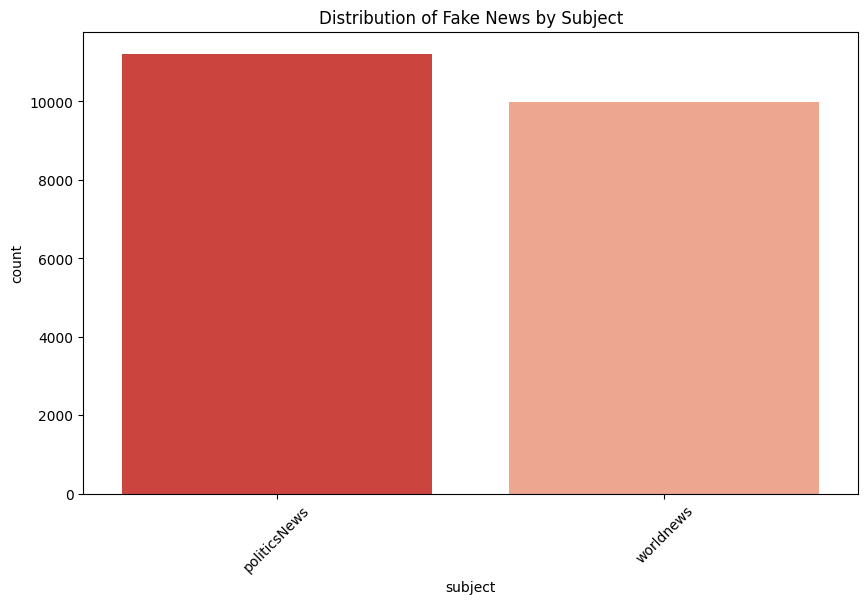

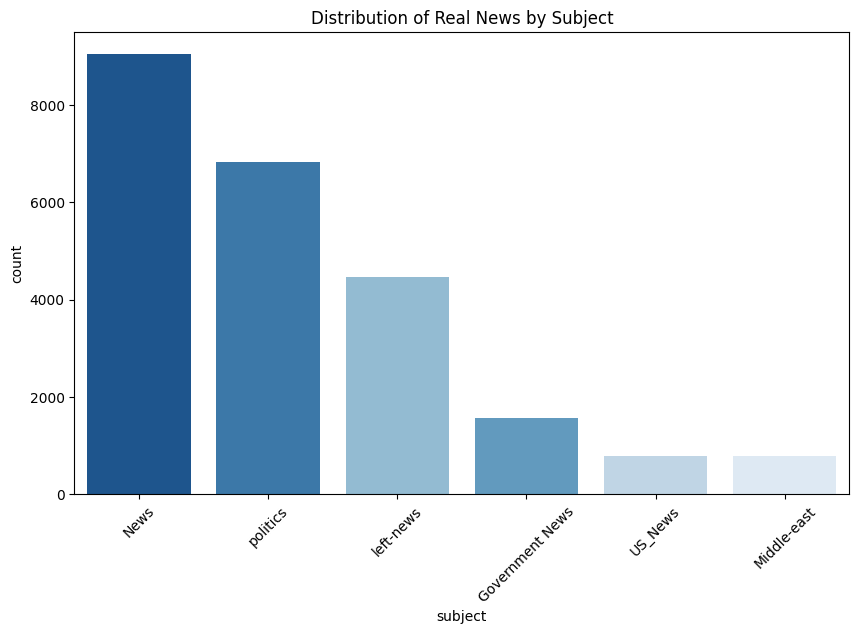

In [27]:
# Fake news by subject
plt.figure(figsize=(10,6))
sns.countplot(
    data=df[df["label"]==1],
    x="subject",
    hue="subject",
    order=df[df["label"]==1]["subject"].value_counts().index,
    palette="Reds_r",
    legend=False
)
plt.title("Distribution of Fake News by Subject")
plt.xticks(rotation=45)
plt.show()

# Real news by subject
plt.figure(figsize=(10,6))
sns.countplot(
    data=df[df["label"]==0],
    x="subject",
    hue="subject",
    order=df[df["label"]==0]["subject"].value_counts().index,
    palette="Blues_r",
    legend=False
)
plt.title("Distribution of Real News by Subject")
plt.xticks(rotation=45)
plt.show()


In [28]:
df.drop(columns=["date","subject"],inplace=True)
df

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0


## 3) Text Preprocessing

In [29]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words and len(tok) > 2]
    return ' '.join(tokens)

# Combine title + text (handles missing)
df['title'] = df['title'].astype(str).fillna('')
df['text'] = df['text'].astype(str).fillna('')
df['clean'] = (df['title'] + ' ' + df['text']).apply(clean_text)

# Quick look at text length
df['len'] = df['clean'].str.split().apply(len)
print(df['len'].describe())

count    44689.000000
mean       238.740294
std        200.835924
min          3.000000
25%        126.000000
50%        212.000000
75%        298.000000
max       4910.000000
Name: len, dtype: float64


### Word Clouds (Fake vs. True)

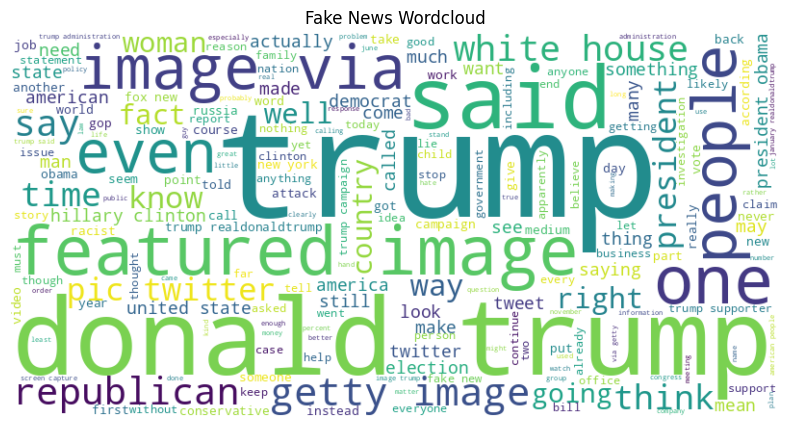

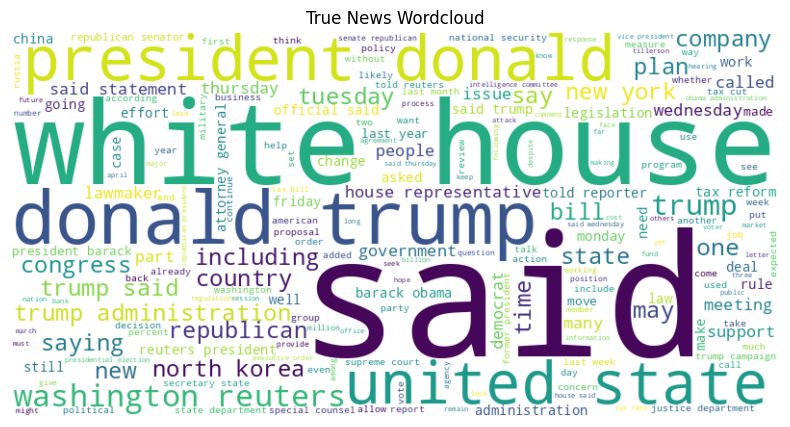

In [30]:
def plot_wordcloud(text, title=''):
    wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

fake_text = ' '.join(df.loc[df['label']==0, 'clean'].head(5000))
true_text = ' '.join(df.loc[df['label']==1, 'clean'].head(5000))

plot_wordcloud(fake_text, 'Fake News Wordcloud')
plot_wordcloud(true_text, 'True News Wordcloud')


In [31]:
from collections import Counter

# Join all fake news text
fake_corpus = ' '.join(df.loc[df['label']==0, 'clean'])

# Tokenize
fake_tokens = fake_corpus.split()

# Count frequencies
fake_counts = Counter(fake_tokens)

# Top 10 fake news words
top_10_fake = fake_counts.most_common(10)
print("Top 10 Fake News Words:")
for word, freq in top_10_fake:
    print(f"{word}: {freq}")

Top 10 Fake News Words:
trump: 89456
said: 33956
president: 29570
people: 27195
one: 26088
state: 24259
would: 23826
obama: 21420
clinton: 21036
time: 19666


In [32]:
# Join all fake news text
true_corpus = ' '.join(df.loc[df['label']==1, 'clean'])

# Tokenize
true_tokens = true_corpus.split()

# Count frequencies
true_counts = Counter(true_tokens)

# Top 10 fake news words
top_10_true = true_counts.most_common(10)
print("Top 10 True News Words:")
for word, freq in top_10_true:
    print(f"{word}: {freq}")

Top 10 True News Words:
said: 97881
trump: 59656
state: 38050
would: 31480
president: 28942
reuters: 28816
republican: 23838
year: 22607
government: 20098
house: 18328


### Key Insights
- **Fake news tends to overuse names (e.g., “trump,” “donald”) and broad, emotional words.**
- **True news relies more on institutional references, credible agencies (like Reuters), and factual context.**
- The **imbalance in attribution (“said”)** is a strong signal: professional journalism attributes statements, while fake news often makes bold claims without clear sources.

✅ This analysis suggests that **word choice and frequency are powerful indicators** in distinguishing fake vs. true news articles.  

## 4) Train/Test Split

In [33]:

X = df['clean'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(len(X_train), len(X_test))


35751 8938


## 5) Baseline Model — TF‑IDF + Logistic Regression (Interpretable)

In [34]:
# TF-IDF vectorizer with reduced max_features
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),     # unigrams + bigrams
    max_features=50000,     # reduced from 200k for efficiency
    min_df=2,               # ignore very rare words
    stop_words='english'    # optional: removes common stopwords
)

# Logistic Regression model
clf = LogisticRegression(max_iter=2000, n_jobs=-1)

# Pipeline
pipe = make_pipeline(tfidf, clf)

# Train
pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# Evaluation
print('\nClassification Report (Baseline)')
print(classification_report(y_test, y_pred, digits=4))

auc = roc_auc_score(y_test, y_proba)
print(f'ROC-AUC: {auc:.4f}')

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)



Classification Report (Baseline)
              precision    recall  f1-score   support

           0     0.9921    0.9845    0.9882      4696
           1     0.9829    0.9913    0.9871      4242

    accuracy                         0.9877      8938
   macro avg     0.9875    0.9879    0.9877      8938
weighted avg     0.9877    0.9877    0.9877      8938

ROC-AUC: 0.9990
Confusion Matrix:
 [[4623   73]
 [  37 4205]]


## 6) Deep Model — LSTM (Optional)

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# --- Tokenization ---
MAX_VOCAB = 20000   # max unique words to keep
MAX_LEN = 200       # max sequence length (truncate/pad)

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

# --- LSTM Model ---
embedding_dim = 128

model = Sequential([
    Embedding(MAX_VOCAB, embedding_dim, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),  # main LSTM layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- Train ---
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,          # increase if needed
    batch_size=64,
    verbose=1
)

# --- Evaluation ---
y_pred_proba = model.predict(X_test_pad).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report (LSTM)")
print(classification_report(y_test, y_pred, digits=4))

auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {auc:.4f}')

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


Epoch 1/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 234s 515ms/step - accuracy: 0.7707 - loss: 0.5909 - val_accuracy: 0.9509 - val_loss: 0.1718
Epoch 2/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 233s 522ms/step - accuracy: 0.9611 - loss: 0.1273 - val_accuracy: 0.9783 - val_loss: 0.0866
Epoch 3/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 256s 509ms/step - accuracy: 0.9929 - loss: 0.0315 - val_accuracy: 0.9887 - val_loss: 0.0473
Epoch 4/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 271s 528ms/step - accuracy: 0.9979 - loss: 0.0113 - val_accuracy: 0.9892 - val_loss: 0.0405
Epoch 5/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 259s 522ms/step - accuracy: 0.9990 - loss: 0.0045 - val_accuracy: 0.9785 - val_loss: 0.1225
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step

Classification Report (LSTM)
              precision    recall  f1-score   support

           0     0.9626    0.9977    0.9798      4696
           1     0.9973    0.9571    0.9768      4242

    accuracy                         0.9784      8938
   macro avg     0.9800    0.9774    0.9783      8938

In [ ]:
### Comparison
Logistic Regression is slightly better overall (higher accuracy, ROC-AUC, recall).
LSTM is more modern and may generalize better if you extend the dataset or use pretrained embeddings.
Both are production-ready, but Logistic Regression is easier to serve in resource-constrained environments.

**Comparison**

*   Logistic Regression is slightly better overall (higher accuracy, ROC-AUC, recall).

*  LSTM is more modern and may generalize better if you extend the dataset or use pretrained embeddings.

Both are production-ready, but Logistic Regression is easier to serve in resource-constrained environments.

In [39]:
# Save in native Keras format (recommended)
model.save("artifacts/lstm_model.keras")

# Load later
from tensorflow.keras.models import load_model
model = load_model("artifacts/lstm_model.keras")

